# An End-to-end Machine Learning project

*Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.*

The following  provide a lot of background for this notebook:

* [Slides](https://www.dropbox.com/s/4hf5mda80qiaxfo/End-to-End-ML-Project-Pipelines-2018-03-08.pdf?dl=0)
* Chapter 2, Hands-On Machine Learning with Scikit-Learn and TensorFlow Concepts, Tools, and Techniques to Build Intelligent Systems, Aurélien Géron,  O'Reilly Media, 2017 (a PDF of this Chapter is available within this directory)

Some of the material in this notebook has been adopted from [here](https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb)

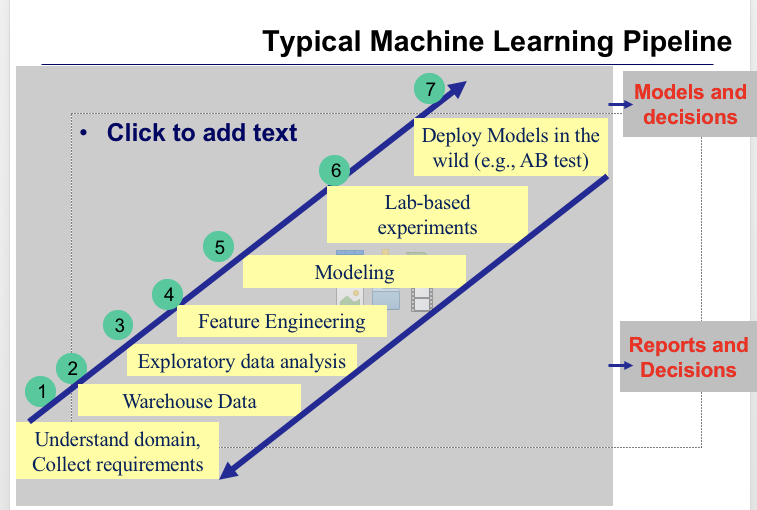

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline.

In [61]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Download the data and do some verifications

The data is located locally within this folder. 

In [62]:
%ls -l datasets/housing/housing.csv

-rw-r--r-- 1 root root 1423529 Mar 27 03:09 datasets/housing/housing.csv


In [63]:
import pandas as pd
import os

HOUSING_PATH = os.path.join("datasets", "housing")
 
def load_housing_data(housing_path=HOUSING_PATH):
 csv_path = os.path.join(housing_path, "housing.csv")
 return pd.read_csv(csv_path)

In [64]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [65]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [66]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [67]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


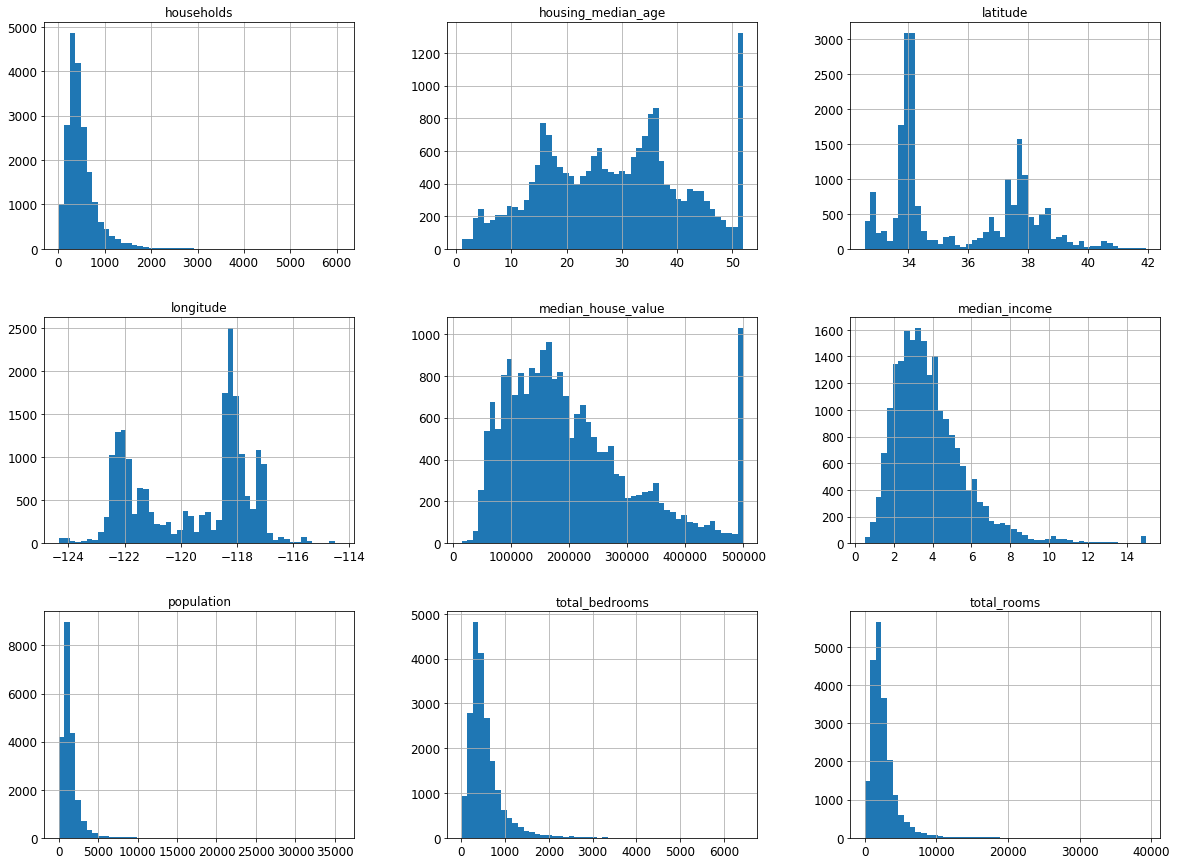

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# Create a heldout test set using different sampling strategies

Here is a short list of sampling strategies:
* Random sample
* Policy-based sampling
* Stratified sample

## Random sample via homegrown code

In [69]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [70]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
# 
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [71]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


## Policy-based sampling

In policy-based sampling, one could compute a hash of each instance’s identifier, keep only the last
byte of the hash, and put the instance in the test set if this value is lower or equal to
51 (~20% of 256 of the last bytes value). This ensures that the test set will remain consistent across multiple
runs, even if you refresh the dataset. The new test set will contain 20% of the new
instances, but it will not contain any instance that was previously in the training set.

In [72]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [73]:
# This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

Unfortunately, the housing dataset does not have an identifier column. The simplest
solution is to use the row index as the ID:

In [74]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data
gets appended to the end of the dataset, and no row ever gets deleted. If this is not
possible, then you can try to use the most stable features to build a unique identifier.
For example, a district’s latitude and longitude are guaranteed to be stable for a few
million years, so you could combine them into an ID like so (NOTE: The location information is actually quite coarse, and as a result many districts will have the exact same ID, so
they will end up in the same set (test or train). This introduces some unfortunate sampling bias.):

In [75]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [76]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


## Scikit-Learn's train_test_split

Scikit-Learn provides a few functions to split datasets into multiple subsets in various
ways. The simplest function is train_test_split, which does pretty much the same
thing as the function split_train_test defined earlier, with a couple of additional
features. First there is a random_state parameter that allows you to set the random
generator seed as explained previously, and second you can pass it multiple datasets
with an identical number of rows, and it will split them on the same indices (this is
very useful, for example, if you have a separate DataFrame for labels):

In [77]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [78]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## Stratified sampling 

## Stratified Sampling 

Perform stratified sampling based upon a categorical variable (that is derived from the data in this case). The derived vsariable is `income_cat`.

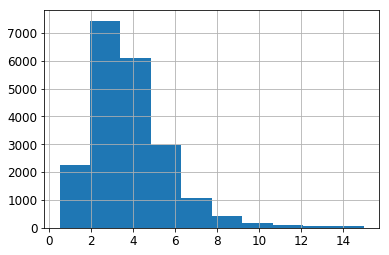

In [79]:
housing["median_income"].hist()

In [80]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [81]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

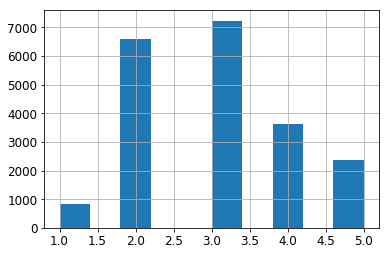

In [82]:
housing["income_cat"].hist()

## Heldout test and train data split for notebook
The `strat_test_set` will be the heldout (aka blind) test set.

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [84]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [85]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [86]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [87]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# EDA Discover and visualize the data to gain insights

## Visualize the location of data sample

Visualize the location of sample: see higher density easier with data dot alpha size =1, and =0.1

In [88]:
housing = strat_train_set.copy()

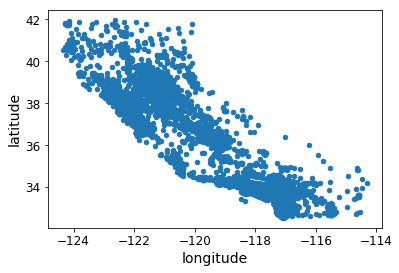

In [89]:
housing.plot(kind="scatter", x="longitude", y="latitude")

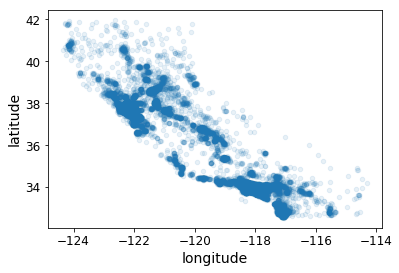

In [90]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

## plot district’s population  versus  price

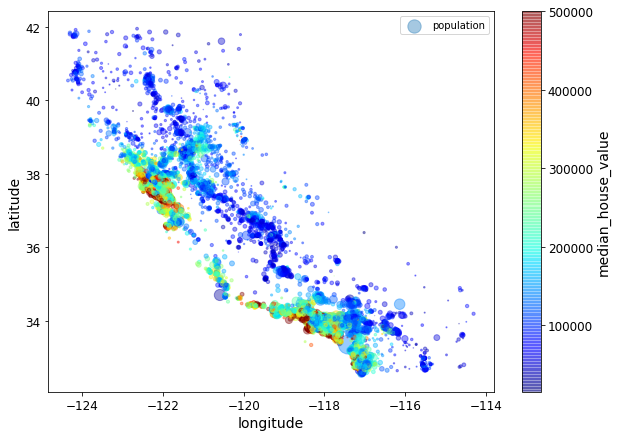

In [91]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 2.0+ MB


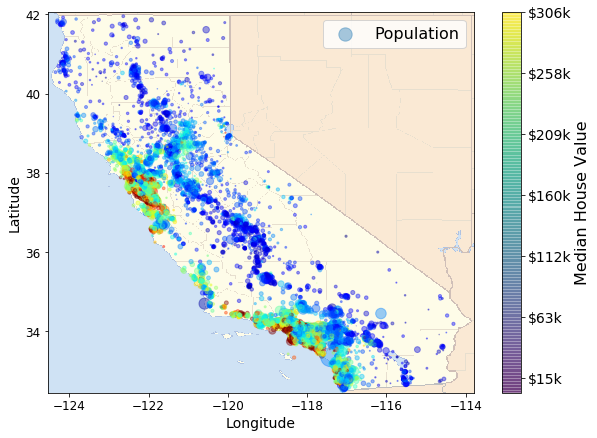

In [92]:
import matplotlib.image as mpimg
california_img=mpimg.imread("california.png")
housing.info()
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## Looking for Correlations
Since the dataset is not too large, you can easily compute the standard correlation
coefficient (also called Pearson’s r) between every pair of attributes using the corr()
method:

In [93]:
corr_matrix = housing.corr()
print(housing.info)

<bound method DataFrame.info of        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
19480    -120.97     37.66                24.0       2930.0           588.0   
8879     -118.50     34.04                52.0       2233.0           317.0   
13685    -117.24     34.15                26.0       2041.0           293.0   
4937     -118.26     33.99                47.0       1865.0           465.0   
4861     -118.28     34.02                29.0        515.0           229.0   
16365    -121.31     38.02                24.0       4157.0           951.0   
19684    -121.62    

In [94]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25d86d17f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f25d8845048>]], dtype=object)

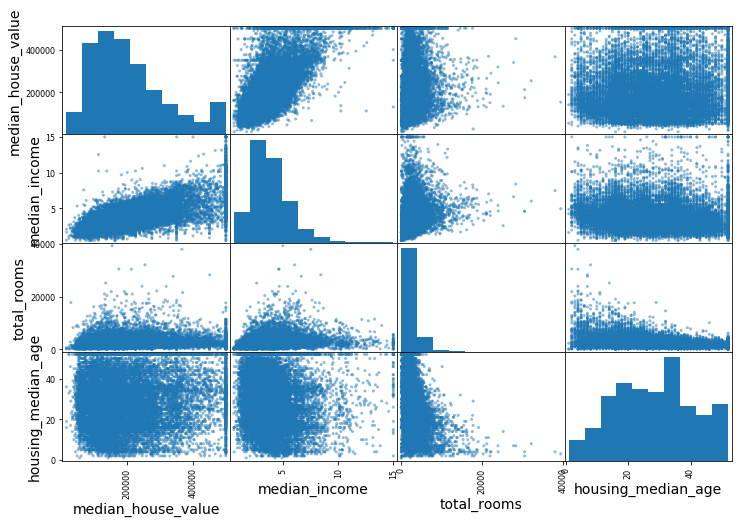

In [95]:
from pandas.tools.plotting import scatter_matrix

# Top three correlated inputs with housing_median_age
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


### Most correlated input with target variable

[0, 16, 0, 550000]

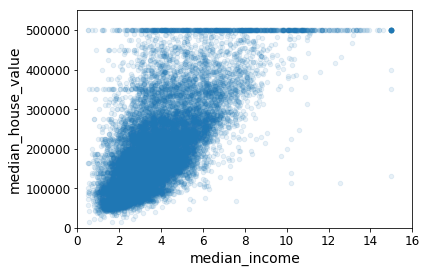

In [96]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

## Derive some new input features
One last thing you may want to do before actually preparing the data for Machine
Learning algorithms is to try out various attribute combinations. For example, the
total number of rooms in a district is not very useful if you don’t know how many
households there are.

In [97]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [98]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

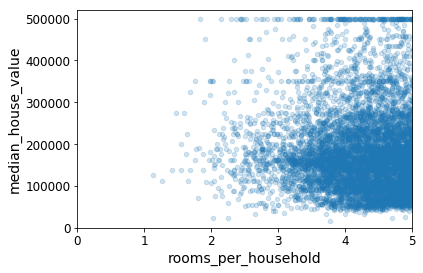

In [99]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [100]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

Most Machine Learning algorithms cannot work with missing features, so let’s create
a few functions to take care of them. You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this. You have three options:
* Get rid of the corresponding districts.
* Get rid of the whole attribute.
* Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s dropna(), drop(), and fillna()
methods:


* `housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
`

If you choose option 3, you should compute the median value on the training set, and
use it to fill the missing values in the training set, but also don’t forget to save the
median value that you have computed. You will need it later to replace missing values
in the test set when you want to evaluate your system, and also once the system goes
live to replace missing values in new data.

In [101]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Deal with missing data


In [102]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [103]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [104]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [105]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [106]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [107]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [108]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [109]:
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Check that this is the same as manually computing the median of each attribute:

In [110]:
housing_num.median().values

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

Transform the training set:

In [111]:
X = imputer.transform(housing_num)

In [112]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [113]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [114]:
imputer.strategy

'median'

In [115]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## Handling Text and Categorical Input Attributes
Earlier we left out the categorical attribute ocean_proximity because it is a text
attribute so we cannot compute its median. Most Machine Learning algorithms prefer
to work with numbers anyway, so let’s convert these text labels to numbers.
In Scikit-Learn this can be a two-step process:

* Transform strings to numbers using LabelEncoder
* One-hot-encode the numeric codes 

Or do it all in **ONE-STEP** using the `CategoricalEncoder` class

### A two-step process for OHE

In [116]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [117]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [118]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [119]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

### A ONE-STEP process for OHE
We can apply both transformations (from text categories to integer categories, then
from integer categories to one-hot vectors) in one shot using the a custom CategoricalEncoder
class `CategoricalEncoder` that works within a pipeline workflow.

In [120]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [121]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot



<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The default encoding is one-hot, and it returns a sparse array. You can use toarray() to get a dense array:

In [122]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

Alternatively, you can specify the encoding to be "onehot-dense" to get a dense matrix rather than a sparse matrix:

In [123]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [124]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

## Derive new inputs via a pipeline step

Create new features via a pipeline:
    
`housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]`

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [126]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Complete pipeline for numerical inputs

In [127]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),  #derive new features 
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [128]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Pipeline for numerical and categorical inputs

In [129]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [130]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
    ])

In [131]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [132]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [133]:
housing_prepared.shape

(16512, 16)

# End-to-end machine learning pipeline
You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote transformation pipelines to clean up and
prepare your data for Machine Learning algorithms automatically. 

You are now ready
to train a Machine Learning model and tune it up!


## Train a linear regression model

Train on the training  data and test on the training data (to verify pipelines are working)

In [134]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [135]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]


Compare against the actual values:

In [136]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [137]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

### MSE on all training data

In [138]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

In [139]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.895990018973

## Train a Decision Tree Regressor
Train on the training  data and test on the training data (to verify pipelines are working)

In [140]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [141]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Wow zero  error on the TRAINING data
We overfit  the train data. How can we do some more objective evaluations?

## Objective evaluation via  K-fold crossfold validation

One way to evaluate the Decision Tree model would be to use the train_test_split
function to split the training set into a smaller training set and a validation set, then
train your models against the smaller training set and evaluate them against the validation
set. It’s a bit of work, but nothing too difficult and it would work fairly well.

A great alternative is to use Scikit-Learn’s *cross-validation* feature. The following code
performs *K-fold cross-validation*: it randomly splits the training set into 10 distinct
subsets called folds, then it trains and evaluates the Decision Tree model 10 times,
picking a different fold for evaluation every time and training on the other 9 folds.
The result is an array containing the 10 evaluation scores:

In [142]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [143]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 70232.0136482   66828.46839892  72444.08721003  70761.50186201
  71125.52697653  75581.29319857  70169.59286164  70055.37863456
  75370.49116773  71222.39081244]
Mean: 71379.0744771
Standard deviation: 2458.31882043


### Minimize MSE is equivalent to maximizing (-MSE)
Grid search will use cross_val_score based on maximizing a utility performance measure. So we maximize(-MSE) here.

In [144]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


In [145]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [146]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [147]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51650.94405471  48920.80645498  52979.16096752  54412.74042021
  50861.29381163  56488.55699727  51866.90120786  49752.24599537
  55399.50713191  53309.74548294]
Mean: 52564.1902524
Standard deviation: 2301.87380392


In [148]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

## SVR SVM for Regression 

In [149]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

## Finetune model/pipeline hyperparameters

Let’s assume at this point that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that:

* GridSearch
* RandomSearch

### Finetune via GridSearch

In the following the `param_grid` tells Scikit-Learn to first evaluate all 3 × 4 = 12 combinations of
`n_estimators` and `max_features` hyperparameter values specified in the first dict
(don’t worry about what these hyperparameters mean for now; they will be explained
in Chapter 7), then try all 2 × 3 = 6 combinations of hyperparameter values in the
second dict, but this time with the `bootstrap` hyperparameter set to `False` instead of
`True` (which is the default value for this hyperparameter).

All in all, the grid search will explore 12 + 6 = 18 combinations of `RandomForestRegressor` hyperparameter values, and it will train each model five times (since we are
using five-fold cross validation). In other words, all in all, there will be 18 × 5 = 90
rounds of training!

In [150]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [151]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Since 8 and 30 are the maximum values that were evaluated, you
should probably try searching again with higher values, since the
score may continue to improve.

You can also get the best estimator directly:

In [152]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [153]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63647.854446 {'max_features': 2, 'n_estimators': 3}
55611.5015988 {'max_features': 2, 'n_estimators': 10}
53370.0640736 {'max_features': 2, 'n_estimators': 30}
60959.1388585 {'max_features': 4, 'n_estimators': 3}
52740.5841667 {'max_features': 4, 'n_estimators': 10}
50374.1421461 {'max_features': 4, 'n_estimators': 30}
58661.2866462 {'max_features': 6, 'n_estimators': 3}
52009.9739798 {'max_features': 6, 'n_estimators': 10}
50154.1177737 {'max_features': 6, 'n_estimators': 30}
57865.3616801 {'max_features': 8, 'n_estimators': 3}
51730.0755087 {'max_features': 8, 'n_estimators': 10}
49694.8514333 {'max_features': 8, 'n_estimators': 30}
62874.4073931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54643.4998083 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59437.8922859 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52735.3582936 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
57490.0168279 {'bootstrap': False, 'max_features': 4, 'n_estima

In [154]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.058730,0.003864,-4.051049e+09,-1.106013e+09,NaN,2,3,"{'max_features': 2, 'n_estimators': 3}",18,-3.850668e+09,...,-4.194135e+09,-1.116843e+09,-3.906732e+09,-1.112813e+09,-4.169669e+09,-1.129842e+09,0.002185,0.000445,1.431223e+08,2.173798e+07
1,0.174768,0.009483,-3.092639e+09,-5.819353e+08,NaN,2,10,"{'max_features': 2, 'n_estimators': 10}",11,-3.052380e+09,...,-3.124982e+09,-5.780873e+08,-2.865117e+09,-5.713421e+08,-3.169914e+09,-5.797944e+08,0.005009,0.000312,1.306954e+08,7.584886e+06
2,0.519020,0.027142,-2.848364e+09,-4.396234e+08,NaN,2,30,"{'max_features': 2, 'n_estimators': 30}",9,-2.692176e+09,...,-2.943808e+09,-4.374429e+08,-2.619893e+09,-4.374715e+08,-2.968460e+09,-4.451903e+08,0.003239,0.001397,1.604534e+08,2.883885e+06
3,0.087854,0.003505,-3.716017e+09,-9.850011e+08,NaN,4,3,"{'max_features': 4, 'n_estimators': 3}",16,-3.729600e+09,...,-3.736527e+09,-9.172986e+08,-3.404974e+09,-1.035901e+09,-3.914186e+09,-9.711998e+08,0.001358,0.000100,1.690029e+08,4.047487e+07
4,0.289510,0.009541,-2.781569e+09,-5.160154e+08,NaN,4,10,"{'max_features': 4, 'n_estimators': 10}",8,-2.667093e+09,...,-2.891599e+09,-4.960301e+08,-2.613393e+09,-5.422542e+08,-2.949550e+09,-5.158794e+08,0.003639,0.000665,1.278498e+08,1.498960e+07
5,0.860352,0.027229,-2.537554e+09,-3.878685e+08,NaN,4,30,"{'max_features': 4, 'n_estimators': 30}",3,-2.387199e+09,...,-2.663178e+09,-3.789712e+08,-2.397951e+09,-4.036920e+08,-2.649850e+09,-3.846171e+08,0.003903,0.001100,1.209935e+08,8.424973e+06
6,0.119310,0.003252,-3.441147e+09,-9.030212e+08,NaN,6,3,"{'max_features': 6, 'n_estimators': 3}",14,-3.119576e+09,...,-3.587747e+09,-9.360639e+08,-3.331544e+09,-9.025026e+08,-3.577062e+09,-8.612945e+08,0.003288,0.000068,1.884229e+08,2.639683e+07
7,0.397368,0.009541,-2.705037e+09,-5.014210e+08,NaN,6,10,"{'max_features': 6, 'n_estimators': 10}",6,-2.553481e+09,...,-2.762945e+09,-4.996537e+08,-2.519522e+09,-4.989516e+08,-2.906270e+09,-5.063617e+08,0.004207,0.000434,1.464963e+08,3.357661e+06
8,1.210553,0.027359,-2.515436e+09,-3.840197e+08,NaN,6,30,"{'max_features': 6, 'n_estimators': 30}",2,-2.371924e+09,...,-2.607962e+09,-3.805596e+08,-2.351220e+09,-3.856159e+08,-2.662399e+09,-3.904866e+08,0.004963,0.001107,1.283580e+08,3.796810e+06
9,0.153049,0.003419,-3.348400e+09,-8.884890e+08,NaN,8,3,"{'max_features': 8, 'n_estimators': 3}",13,-3.351347e+09,...,-3.396841e+09,-8.596460e+08,-3.131753e+09,-8.893698e+08,-3.509451e+09,-9.146734e+08,0.001205,0.000145,1.226683e+08,2.730057e+07


### Finetune model using RandomizedSearchCV

The grid search approach is fine when you are exploring relatively few combinations,
like in the previous example, but when the hyperparameter search space is large, it is
often preferable to use RandomizedSearchCV instead. This class can be used in much
the same way as the GridSearchCV class, but instead of trying out all possible combinations,
it evaluates a given number of random combinations by selecting a random
value for each hyperparameter at every iteration. This approach has two main benefits:

* If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
*  You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

Overall, random search gives more bang for the buck and approximates the performance distribution curve more closely. We get more samples across the important dimension in the case of the figure presented below (as opposed to 3 in Grid search). GridSearch gives us a uniform distribution whereas the randomsearch builds a more complete version of the distribution (along the x-axis) in this artifical example.

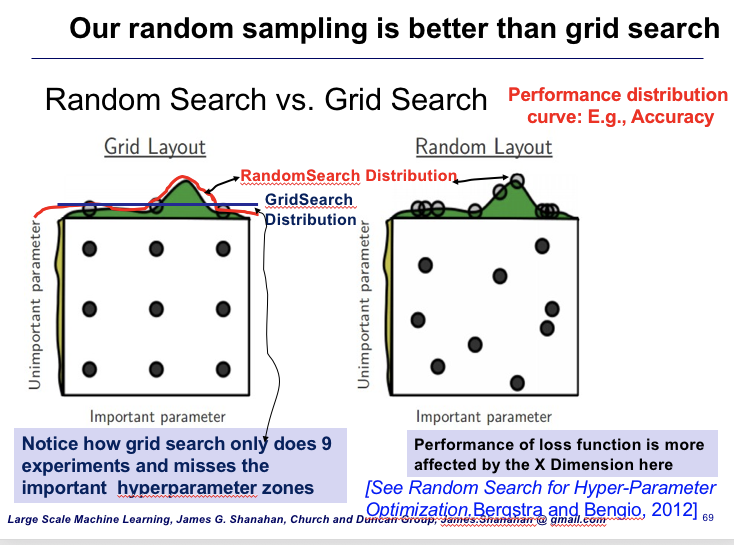 



In [155]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f25d99e6a58>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f25d99e6d68>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=0)

### Random Search for 10 experiments

In [156]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49147.1524172 {'max_features': 7, 'n_estimators': 180}
51396.8768969 {'max_features': 5, 'n_estimators': 15}
50797.0573732 {'max_features': 3, 'n_estimators': 72}
50840.744514 {'max_features': 5, 'n_estimators': 21}
49276.1753033 {'max_features': 7, 'n_estimators': 122}
50775.4633168 {'max_features': 3, 'n_estimators': 75}
50681.383925 {'max_features': 3, 'n_estimators': 88}
49612.1525305 {'max_features': 5, 'n_estimators': 100}
50473.0175142 {'max_features': 3, 'n_estimators': 150}
64458.2538503 {'max_features': 5, 'n_estimators': 2}


## Input variable importance 
Let's look at the best model. You will often gain good insights on the problem by inspecting the best models. For
example, the RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

In [157]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([  7.33442355e-02,   6.29090705e-02,   4.11437985e-02,
         1.46726854e-02,   1.41064835e-02,   1.48742809e-02,
         1.42575993e-02,   3.66158981e-01,   5.64191792e-02,
         1.08792957e-01,   5.33510773e-02,   1.03114883e-02,
         1.64780994e-01,   6.02803867e-05,   1.96041560e-03,
         2.85647464e-03])

In [158]:
print(encoder)

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)


In [159]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)
sortedFeatures

[(6.0280386727365991e-05, 'ISLAND'),
 (0.0019604155994780701, 'NEAR BAY'),
 (0.0028564746373201579, 'NEAR OCEAN'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.014257599323407807, 'households'),
 (0.014672685420543237, 'total_rooms'),
 (0.014874280890402767, 'population'),
 (0.041143798478729635, 'housing_median_age'),
 (0.053351077347675809, 'bedrooms_per_room'),
 (0.056419179181954007, 'rooms_per_hhold'),
 (0.062909070482620302, 'latitude'),
 (0.073344235516012421, 'longitude'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.16478099356159051, 'INLAND'),
 (0.36615898061813418, 'median_income')]

In [ ]:
np.array(sortedFeatures)[:, 0]

In [ ]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

# Blind test on heldout dataset

Here we see how generalize on a proxy for the real world via a heldout test set.

In [2]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

NameError: name 'grid_search' is not defined

In [ ]:
final_rmse

To visualize the differences between actual prices and predicted values we also create a scatter plot. Notice any issues? We have a problem with the  500k actuals. That would be the next problem to address.

In [3]:
plt.scatter(y_test, final_predictions)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")
plt.grid()

NameError: name 'plt' is not defined

## Statistically significantly blind test on heldout dataset
In addition, one could blind test a number of competing pipelines at this time by t-testing via crossfold-based sampling with k=30 to get a sense of how different pipelines might play in a production setting (in the wild, aka in a bucket test, aka AB-testing mode).  See a later section for more details.

# A full pipeline with both preparation and prediction

In [4]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

NameError: name 'Pipeline' is not defined

## Model persistence using joblib

In [5]:
my_model = full_pipeline_with_predictor

NameError: name 'full_pipeline_with_predictor' is not defined

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

# Is my ML pipeline statistically significantly better?

In this section, you will discover how you can investigate and interpret machine learning experimental results using statistical significance tests in Python.

In statistical hypothesis testing, a result has statistical significance when it is very unlikely to have occurred given the null hypothesis. More precisely, a study's defined significance level, α, is the probability of the study rejecting the null hypothesis, given that it were true; and the p-value of a result, p, is the probability of obtaining a result at least as extreme, given that the null hypothesis were true. The result is statistically significant, by the standards of the study, when p < α. For more background see [here](https://en.wikipedia.org/wiki/Statistical_significance)

The significance level for a study is chosen before data collection, and typically set to 5% or much lower, depending on the field of study. In any experiment or observation that involves drawing a sample from a population, there is always the possibility that an observed effect would have occurred due to sampling error alone. But if the p-value of an observed effect is less than the significance level, an investigator may conclude that the effect reflects the characteristics of the whole population, thereby rejecting the null hypothesis. This technique for testing the significance of results was developed in the early 20th century.

Statistical significance tests are an important tool to help to interpret the results from machine learning experiments. Additionally, the findings from these tools can help one better and more confidently present  experimental results and choose the right algorithms and configurations for a predictive modeling problem. 
Here we will adapt statistical hypothesis testing to see if one model should be preferred over another based on a pair evaluation on a heldout test set.



## Example paired t-test
We will measure the amount of sleep got by patients before and after taking soporific drugs to help them sleep.

The null hypothesis is that the soporific drug has no effect on the sleep duration of the patients.

Scipy implements the paired t-test as `ttest_rel()`

For more background see [here](https://en.wikipedia.org/wiki/T-test#Dependent_t-test_for_paired_samples).

In [6]:
import numpy as np
from scipy import stats

control = [8.0, 7.1, 6.5, 6.7, 7.2, 5.4, 4.7, 8.1, 6.3, 4.8]
treatment = [9.9, 7.9, 7.6, 6.8, 7.1, 9.9, 10.5, 9.7, 10.9, 8.2]

#paired t-test; two-tailed p-value
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00553 for a z-score of -3.62449."

#in the case of regression lower RMSE is better
#If RMSE for system A (Control) is 8.0 and the RMSE for system B (treatment) is 9.0
#then the difference (A-B) is -1; so negative tScores meant System A is better than System B

if p_value > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0: #in the case of regression lower RMSE is better; A is lower 
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')
    

The p-value is 0.00553 for a t-score of -3.62449.
The two machine learning pipelines are different (reject H0) 
(t_score, p_value) = (-3.62, 0.00553)
Machine learning pipeline A is better than B


Our t-statistic value is -3.624, and along with our degrees of freedom (9) this can be used to calculate a p-value.

The p-value is 0.0055, which again is below than the standard thresholds of 0.05/2 or 0.01/2, so we reject the null hypothesis and we can say there is a statistically significant difference in sleep duration caused by the soporific drug.

## StatSig Test full example for  ML pipelines via crossfold validation
In the case of machine learning (using SKLearn), let's assume the **CONTROL** is a BASELINE system, say a linear regression, and the **TREATMENT** is a decision tree regression model (with all default settings). 

1. We run both systems on using k-fold cross validation with k=30 using a regression performance metrics such as RMSE.
   *  Each system produces an array of 30 values of the performance metric being considered: control and treatment.
* Perform a two-sided t-test to determine if there there is a statistically significant difference between the control and treatment as follows:


<PRE>
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a z-score of %0.5f." %(p_value, t_score))

#"The p-value is 0.0005 for a z-score of 3.62449."</PRE>

Let's assume the t-statistic value is 3.624, and along with our degrees of freedom (29) this can be used to calculate a p-value for out ML pipeline evaluation.

The corresponding p-value is 0.0005, which again is below than the standard thresholds of 0.025 or 0.005, so we reject the null hypothesis and we can say there is a statistically significant difference in the models and is likely to be caused by the use of decision trees.

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# A sampling based bakeoff using *K-fold cross-validation*: 
# it randomly splits the training set into K distinct subsets (k=30)
# this bakeoff framework can be used for regression or classification
#Control system is a linear regression based pipeline

kFolds=30
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=kFolds)
control = lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

#Treatment system is a Decision Tree regression based pipeline
tree_reg = DecisionTreeRegressor(random_state=42)
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=kFolds)
treatment = tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

#paired t-test; two-tailed p-value (aka two-sided)
(t_score, p_value) = stats.ttest_rel(control, treatment)
print("The p-value is %0.5f for a t-score of %0.5f." %(p_value, t_score))
#"The p-value is 0.00019 for a t-score of -4.28218." 
if pvalue > 0.05/2:  #Two sided 
    print('There is no significant difference between the two machine learning pipelines (Accept H0)')
else:
    print('The two machine learning pipelines are different (reject H0) \n(t_score, p_value) = (%.2f, %.5f)'%(t_score, p_value) )
    if t_score < 0.0:
        print('Machine learning pipeline A is better than B')
    else:
        print('Machine learning pipeline B is better than A')
        
    

NameError: name 'housing_prepared' is not defined

The p-value is 0.00019 for a z-score of -4.28218, along with our degrees of freedom (29) means that the Control system is statistically different (we can say better).

Based on the p-value of 0.00019 for a z-score of -4.28218, we can reject the null hypothesis. (Statisticians like us to say reject the null rather than accept the alternative.) There is statistically significant evidence that SystemA (LR-based) predicts better on average than SystemB (DT-based) at a significance level of 0.05. The p-value shows there is a 0.019% chance that our results occurred because of random noise.


The corresponding p-value is 0.00019 , which again is below than the standard thresholds of 0.025 or 0.005, so we reject the null hypothesis and we can say there is a statistically significant difference in the models and is likely to be caused by the use of decision trees.  The p-value in the test output shows that the chances of seeing this large of a difference between samples due to chance (assuming the H0, the null hypothesis, is true) is just  0.019%.

Based upon this bakeoof (highly limited) we would select Linear regression and possibly deploy it into production. (In the real world, we would do lots more lab-based experimentation).


#  Questions and Answers on other SKLearn pipelines

Using the same Californian dataset presented above to solve the following homework problems.

## 1. Gridsearch

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

NameError: name 'SVR' is not defined

The best model achieves the following score (evaluated using 5-fold cross validation):

In [9]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

NameError: name 'grid_search' is not defined

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [10]:
grid_search.best_params_

NameError: name 'grid_search' is not defined

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

Question: Repeat the above questions by replacing `GridSearchCV` with `RandomizedSearchCV`. Report and discuss your findings.

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

NameError: name 'SVR' is not defined

The best model achieves the following score (evaluated using 5-fold cross validation):

In [12]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

NameError: name 'rnd_search' is not defined

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [13]:
rnd_search.best_params_

NameError: name 'rnd_search' is not defined

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [14]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

NameError: name 'plt' is not defined

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [15]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

NameError: name 'plt' is not defined

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3. Feature Selection

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [17]:
k = 5

Now let's look for the indices of the top k features:

In [18]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

NameError: name 'feature_importances' is not defined

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [19]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

NameError: name 'feature_importances' is not defined

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [20]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

NameError: name 'Pipeline' is not defined

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [21]:
housing_prepared_top_k_features[0:3]

NameError: name 'housing_prepared_top_k_features' is not defined

Now let's double check that these are indeed the top k features:

In [22]:
housing_prepared[0:3, top_k_feature_indices]

NameError: name 'housing_prepared' is not defined

Works great!  :)

## 4. Full pipeline for data prep, feature selection and modeling

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [23]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

NameError: name 'Pipeline' is not defined

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [24]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

NameError: name 'housing' is not defined

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5. Use the full pipeline

Question: Automatically explore some preparation options using `GridSearchCV`.

In [25]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

NameError: name 'prepare_select_and_predict_pipeline' is not defined

In [ ]:
grid_search_prep.best_params_

Great! It seems that we had the right imputer stragegy (mean), and apparently only the top 7 features are useful (out of 9), the last 2 seem to just add some noise.

In [26]:
housing.shape

NameError: name 'housing' is not defined

Congratulations! You already know quite a lot about Machine Learning. :)

# Homework  Task

Adopt the above end machine learning pipeline tackle the Titanic problem. The Lab for the Titanic problem from Unit 01 located here [here]( https://www.dropbox.com/sh/y1y3t2hqbetvx86/AACDq7-sv_zh23w6GCfE6Eqra?dl=0)



<PRE>
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("logRegression", LogisticRegression())
    ])

</PRE>

Explore many different learning algorithms (at least one)  and hyperparamter settings (optimize!). 


## Homework Results Report
Please use this section to consolidate the results of all experiments and discuss your findings and recommendations for this prediction task (predict median house values in Californian districts).

Please report the following table of performance statistics for each task on the train, validation and testssets. In addition provide a block diagram detailing the best architecture used for each of the three tasks in this assignment. 

With regard to a results table, for each of the tasks  please report the following:

* Hardware used
* Experiment ID
* Accuracy Score/F1
* p-value for current model versus a baseline model (please pick a strong baseline!)
* The duration of training in wallclock time (in seconds)
* The duration of testing in wallclock time (in seconds)
* Experiment description
* Kaggle Score

Please use a logging table structure like this to keep track of your experiments and make sure to embed them in your notebook (along with a brief description and discussion that is provided outside the table!):

Answer

# Read the data and do some verifications

In [27]:
from pandas import Series, DataFrame
from sklearn import datasets, svm
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
import pandas as pd
import time

In [28]:
"""
    Variables for the Titanic DataSet asre defined as below:
    
    Training Data:
    
    titanic_train: Training DataFrame with all cleaning (Remove all NaN's and useless features)
    titanic_train_label: Training Labels
    titanic_train_num: Numerical DataFrame (Subset of titanic_train with columns having numerical values only)
    titanic_train_cat: Categorical Dataframe (Subset of titanic_train with columns having non-numerical values)
    titanic_prepared: Final Training dataframe prepared after Scaling, Cleaning and Encoding
    
    Test Data:
    
    titanic_test:Test DataFrame with all cleaning (Remove all NaN's and useless features)
    titanic_test_label:Test Labels
"""  

"\n    Variables for the Titanic DataSet asre defined as below:\n    \n    Training Data:\n    \n    titanic_train: Training DataFrame with all cleaning (Remove all NaN's and useless features)\n    titanic_train_label: Training Labels\n    titanic_train_num: Numerical DataFrame (Subset of titanic_train with columns having numerical values only)\n    titanic_train_cat: Categorical Dataframe (Subset of titanic_train with columns having non-numerical values)\n    titanic_prepared: Final Training dataframe prepared after Scaling, Cleaning and Encoding\n    \n    Test Data:\n    \n    titanic_test:Test DataFrame with all cleaning (Remove all NaN's and useless features)\n    titanic_test_label:Test Labels\n"

In [29]:
# Training Data
titanic_train = pd.read_csv("data/train.csv") 

# Test Data
titanic_test = pd.read_csv("data/test.csv")
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [31]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [32]:
titanic_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [33]:
corr_matrix = titanic_train.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

# Deal with Missing Data

In [34]:
# Missing Data in Training Set
rows_with_missingvalues_Train = titanic_train[titanic_train.isnull().any(axis=1)]

rows_with_missingvalues_Train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S


In [35]:
# Missing Data in Test Set
rows_with_missingvalues_Test = titanic_test[titanic_test.isnull().any(axis=1)]

rows_with_missingvalues_Test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## Replace missing ages with median (For Training Data

In [36]:
# determine mean age based on Sex and Pclass

mean_ages_train = titanic_train.groupby(['Sex','Pclass'])['Age'].mean()

# Function to replace missing ages with median of ages belonging to that Pclass
def remove_missing_ages(missingrow):
    
    #function to check if the age is null for specific class and replace with the mean.
    if pd.isnull(missingrow['Age']):
        return mean_ages_train[missingrow['Sex'],missingrow['Pclass']]
    else:
        return missingrow['Age']


titanic_train['Age'] = titanic_train.apply(remove_missing_ages, axis=1)

## Replace missing ages with median (For Test Data)

In [37]:
# determine mean age based on Sex and Pclass

mean_ages_test = titanic_test.groupby(['Sex','Pclass'])['Age'].mean()
# Function to replace missing ages with median of ages belonging to that Pclass
def remove_missing_ages_test(missingrow):
    
    #function to check if the age is null for specific class and replace with the mean.
    if pd.isnull(missingrow['Age']):
        return mean_ages_test[missingrow['Sex'],missingrow['Pclass']]
    else:
        return missingrow['Age']


titanic_test['Age'] = titanic_test.apply(remove_missing_ages_test, axis=1)

## Missing Embarkation

In [38]:
missing_Embark_Train = titanic_train[titanic_train['Embarked'].isnull()]
missing_Embark_Train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [39]:
missing_Embark_Test = titanic_test[titanic_test['Embarked'].isnull()]
missing_Embark_Test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [40]:
# In Training dataset there are two Embarked with null values and in test data there is no null value
# Use S as Embarkation 
titanic_train['Embarked'].fillna('S',inplace=True)

# Feature Selection

## Combine sipSp and Parch

In [41]:
def family_size(titanic_train, titanic_test):
    for i in [titanic_train, titanic_test]:
        i['Family_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , '0',
                           np.where((i['SibSp']+i['Parch']) <= 3,'1', '2'))
        del i['SibSp']
        del i['Parch']
    return titanic_train, titanic_test

family_size(titanic_train, titanic_test)
titanic_test

,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_Size
0,892,3,"Kelly, Mr. James",male,34.500000,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.000000,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,3101298,12.2875,NaN,S,1
5,897,3,"Svensson, Mr. Johan Cervin",male,14.000000,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,30.000000,330972,7.6292,NaN,Q,0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.000000,248738,29.0000,NaN,S,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.000000,2657,7.2292,NaN,C,0
9,901,3,"Davies, Mr. John Samuel",male,21.000000,A/4 48871,24.1500,NaN,S,1


## Name and Titles

In [42]:
def name_feature(titanic_train, titanic_test):
    for i in [titanic_train, titanic_test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        del i['Name']
    return titanic_train, titanic_test
 
name_feature(titanic_train, titanic_test)
titanic_train

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_Size,Name_Len
0,1,0,3,male,22.000000,A/5 21171,7.2500,NaN,S,1,23
1,2,1,1,female,38.000000,PC 17599,71.2833,C85,C,1,51
2,3,1,3,female,26.000000,STON/O2. 3101282,7.9250,NaN,S,0,22
3,4,1,1,female,35.000000,113803,53.1000,C123,S,1,44
4,5,0,3,male,35.000000,373450,8.0500,NaN,S,0,24
5,6,0,3,male,26.507589,330877,8.4583,NaN,Q,0,16
6,7,0,1,male,54.000000,17463,51.8625,E46,S,0,23
7,8,0,3,male,2.000000,349909,21.0750,NaN,S,2,30
8,9,1,3,female,27.000000,347742,11.1333,NaN,S,1,49
9,10,1,2,female,14.000000,237736,30.0708,NaN,C,1,35


## Remove unused columns like Cabin, Name and Ticket and split Labels

In [43]:
median_Fare = titanic_test["Fare"].median()
titanic_train_label = titanic_train["Survived"]
titanic_train = titanic_train.drop(['Cabin','Ticket','Survived','PassengerId'], axis=1)
test_passengerId = titanic_test['PassengerId']
titanic_test = titanic_test.drop(['Cabin','Ticket','PassengerId'], axis=1)
titanic_test["Fare"].fillna(median_Fare, inplace=True)
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
Fare           418 non-null float64
Embarked       418 non-null object
Family_Size    418 non-null object
Name_Len       418 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 22.9+ KB


In [44]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
Fare           891 non-null float64
Embarked       891 non-null object
Family_Size    891 non-null object
Name_Len       891 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 48.8+ KB


# Handling Text and Categorical Input Attributes

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse
import numpy as np
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [46]:
titanic_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family_Size,Name_Len
0,3,male,22.0,7.2500,S,1,23
1,1,female,38.0,71.2833,C,1,51
2,3,female,26.0,7.9250,S,0,22
3,1,female,35.0,53.1000,S,1,44
4,3,male,35.0,8.0500,S,0,24


In [47]:
titanic_test.head()

,Pclass,Sex,Age,Fare,Embarked,Family_Size,Name_Len
0,3,male,34.5,7.8292,Q,0,16
1,3,female,47.0,7.0000,S,1,32
2,2,male,62.0,9.6875,Q,0,25
3,3,male,27.0,8.6625,S,0,16
4,3,female,22.0,12.2875,S,1,44


In [48]:
cat_encoder = CategoricalEncoder()
titanic_train_cat = titanic_train[["Sex","Embarked"]]
titanic_train_num = titanic_train.drop(["Sex","Embarked"], axis=1)
titanic_train_cat_reshaped = titanic_train_cat.values.reshape(-2, 2)
titanic_train_cat_1hot = cat_encoder.fit_transform(titanic_train_cat_reshaped)
cat_encoder.categories_

[array(['female', 'male'], dtype=object), array(['C', 'Q', 'S'], dtype=object)]

# Pipeline for numerical and categorical inputs (Train Set)

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [50]:
num_attribs_train = list(titanic_train_num)
cat_attribs_train = list(titanic_train_cat)

num_pipeline_train = Pipeline([
        ('selector', DataFrameSelector(num_attribs_train)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline_train = Pipeline([
        ('selector', DataFrameSelector(cat_attribs_train)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
    ])

In [51]:
from sklearn.pipeline import FeatureUnion

full_pipeline_train = FeatureUnion(transformer_list=[
        ("num_pipeline_train", num_pipeline_train),
        ("cat_pipeline_train", cat_pipeline_train),
    ])

In [52]:
titanic_prepared_train = full_pipeline_train.fit_transform(titanic_train)
titanic_prepared_train.shape

(891, 10)

# Pipeline for numerical and categorical inputs (Test Set)

In [53]:
titanic_test_cat = titanic_test[["Sex","Embarked"]]
titanic_test_num = titanic_test.drop(["Sex","Embarked"], axis=1)
titanic_test_cat_reshaped = titanic_test_cat.values.reshape(-2, 2)
titanic_test_cat_1hot = cat_encoder.fit_transform(titanic_test_cat_reshaped)


num_attribs_Test = list(titanic_test_num)
cat_attribs_Test = list(titanic_test_cat)

num_pipeline_test = Pipeline([
        ('selector', DataFrameSelector(num_attribs_Test)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline_test = Pipeline([
        ('selector', DataFrameSelector(cat_attribs_Test)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense"))
    ])
full_pipeline_test = FeatureUnion(transformer_list=[
        ("num_pipeline_test", num_pipeline_test),
        ("cat_pipeline_test", cat_pipeline_test),
    ])
titanic_prepared_test = full_pipeline_test.fit_transform(titanic_test)
titanic_prepared_test.shape

(418, 10)

# Train a Logistic Regression Model

## Prepare Table to log results for various Models

In [54]:
results = pd.DataFrame(columns=["Hardware", "ExpID", "Accuracy", "p-value","TrainTime(s)", "TestTime(s)", "Experiment description"])

results

,Hardware,ExpID,Accuracy,p-value,TrainTime(s),TestTime(s),Experiment description


## Split prepared training data to train and test for validation

In [55]:
from sklearn.model_selection import train_test_split

train_set, test_set, train_label, test_label = train_test_split(titanic_prepared_train,titanic_train_label, test_size=0.2, random_state=42)

In [56]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
start_time_train_lg = time.time()
log_reg.fit(train_set, train_label)
processing_time_train_lg = (time.time()-start_time_train_lg)
log_reg.predict(test_set)
accuracy_score = log_reg.score(test_set,test_label)

# Log Results in Table
                               
results.loc[len(results)] = ["Macbook Pro","1",accuracy_score,"NA",processing_time_train_lg,processing_time_train_lg,"Logistic Regression"]
results

,Hardware,ExpID,Accuracy,p-value,TrainTime(s),TestTime(s),Experiment description
0,Macbook Pro,1,0.821229,NA,0.009458,0.009458,Logistic Regression


## Objective evaluation via K-fold crossfold validation

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, titanic_prepared_train, titanic_train_label,
                         scoring='accuracy', cv=10)
results.loc[len(results)] = ["Macbook Pro","2",accuracy_score,"NA","NA","NA","Crossfold Validation"]
results

,Hardware,ExpID,Accuracy,p-value,TrainTime(s),TestTime(s),Experiment description
0,Macbook Pro,1,0.821229,NA,0.00945807,0.00945807,Logistic Regression
1,Macbook Pro,2,0.821229,NA,NA,NA,Crossfold Validation


## Run Logistic Regression on original Test data for Kaggle submission

In [58]:
start_time_test_lg = time.time()
predict_test_logistic = log_reg.predict(titanic_prepared_test)
processing_time_test_lg = (time.time()-start_time_test_lg)

predict_test_dataframe_lg=pd.DataFrame(predict_test_logistic)
predict_test_dataframe_lg=predict_test_dataframe_lg.rename(columns = {0:'Survived'})
passengerId = pd.DataFrame(test_passengerId)
final_predict_logistic = passengerId.join(predict_test_dataframe_lg)
final_predict_logistic.to_csv('saurabhiu_titanic_pred_logistic.csv',sep=',')

# Train a Random Forest Model

In [59]:
from sklearn.ensemble import RandomForestClassifier

random_forest_reg = RandomForestClassifier()
start_time_train_rf = time.time()
random_forest_reg.fit(train_set, train_label)
processing_time_train_rf = (time.time()-start_time_train_rf)
start_time_test_rf  = time.time()
random_forest_reg.predict(test_set)
processing_time_test_rf = (time.time()-start_time_test_rf)
accuracy_score_rf = random_forest_reg.score(test_set,test_label)

# Log Results in Table
                               
results.loc[len(results)] = ["Macbook Pro","1",accuracy_score_rf,"NA",processing_time_train_rf,processing_time_test_rf,"Random Forest Regression"]
results

,Hardware,ExpID,Accuracy,p-value,TrainTime(s),TestTime(s),Experiment description
0,Macbook Pro,1,0.821229,NA,0.00945807,0.00945807,Logistic Regression
1,Macbook Pro,2,0.821229,NA,NA,NA,Crossfold Validation
2,Macbook Pro,1,0.832402,NA,0.0140412,0.00143075,Random Forest Regression


## Run Random Forest Regression on original Test data for Kaggle submission

In [60]:
start_time_test_rf = time.time()


predict_test_randomforest = random_forest_reg.predict(titanic_prepared_test)
processing_time_test_rf = (time.time()-start_time_test_rf)

predict_test_dataframe_rf=pd.DataFrame(predict_test_randomforest)
predict_test_dataframe_rf=predict_test_dataframe_rf.rename(columns = {0:'Survived'})

final_predict_randomforest = passengerId.join(predict_test_dataframe_rf)

final_predict_randomforest.to_csv('saurabhiu_titanic_pred_randomforest.csv',sep=',')

## Submit to Kaggle and screenshot your ranking:
Using your Titanic Survival pipeline, prepare a submission to the Kaggle Titanic competition. For details on how to do this see [here]( https://www.kaggle.com/c/titanic).

For your best run, please paste a screenshot of your ranking on the Kaggle Titanic competition scoreboard here (make sure the cell is in markdown mode; then paste the image/screen shot in the cell; then execute the cell. Please report your rank, accuracy, and Kaggle username in text here also.

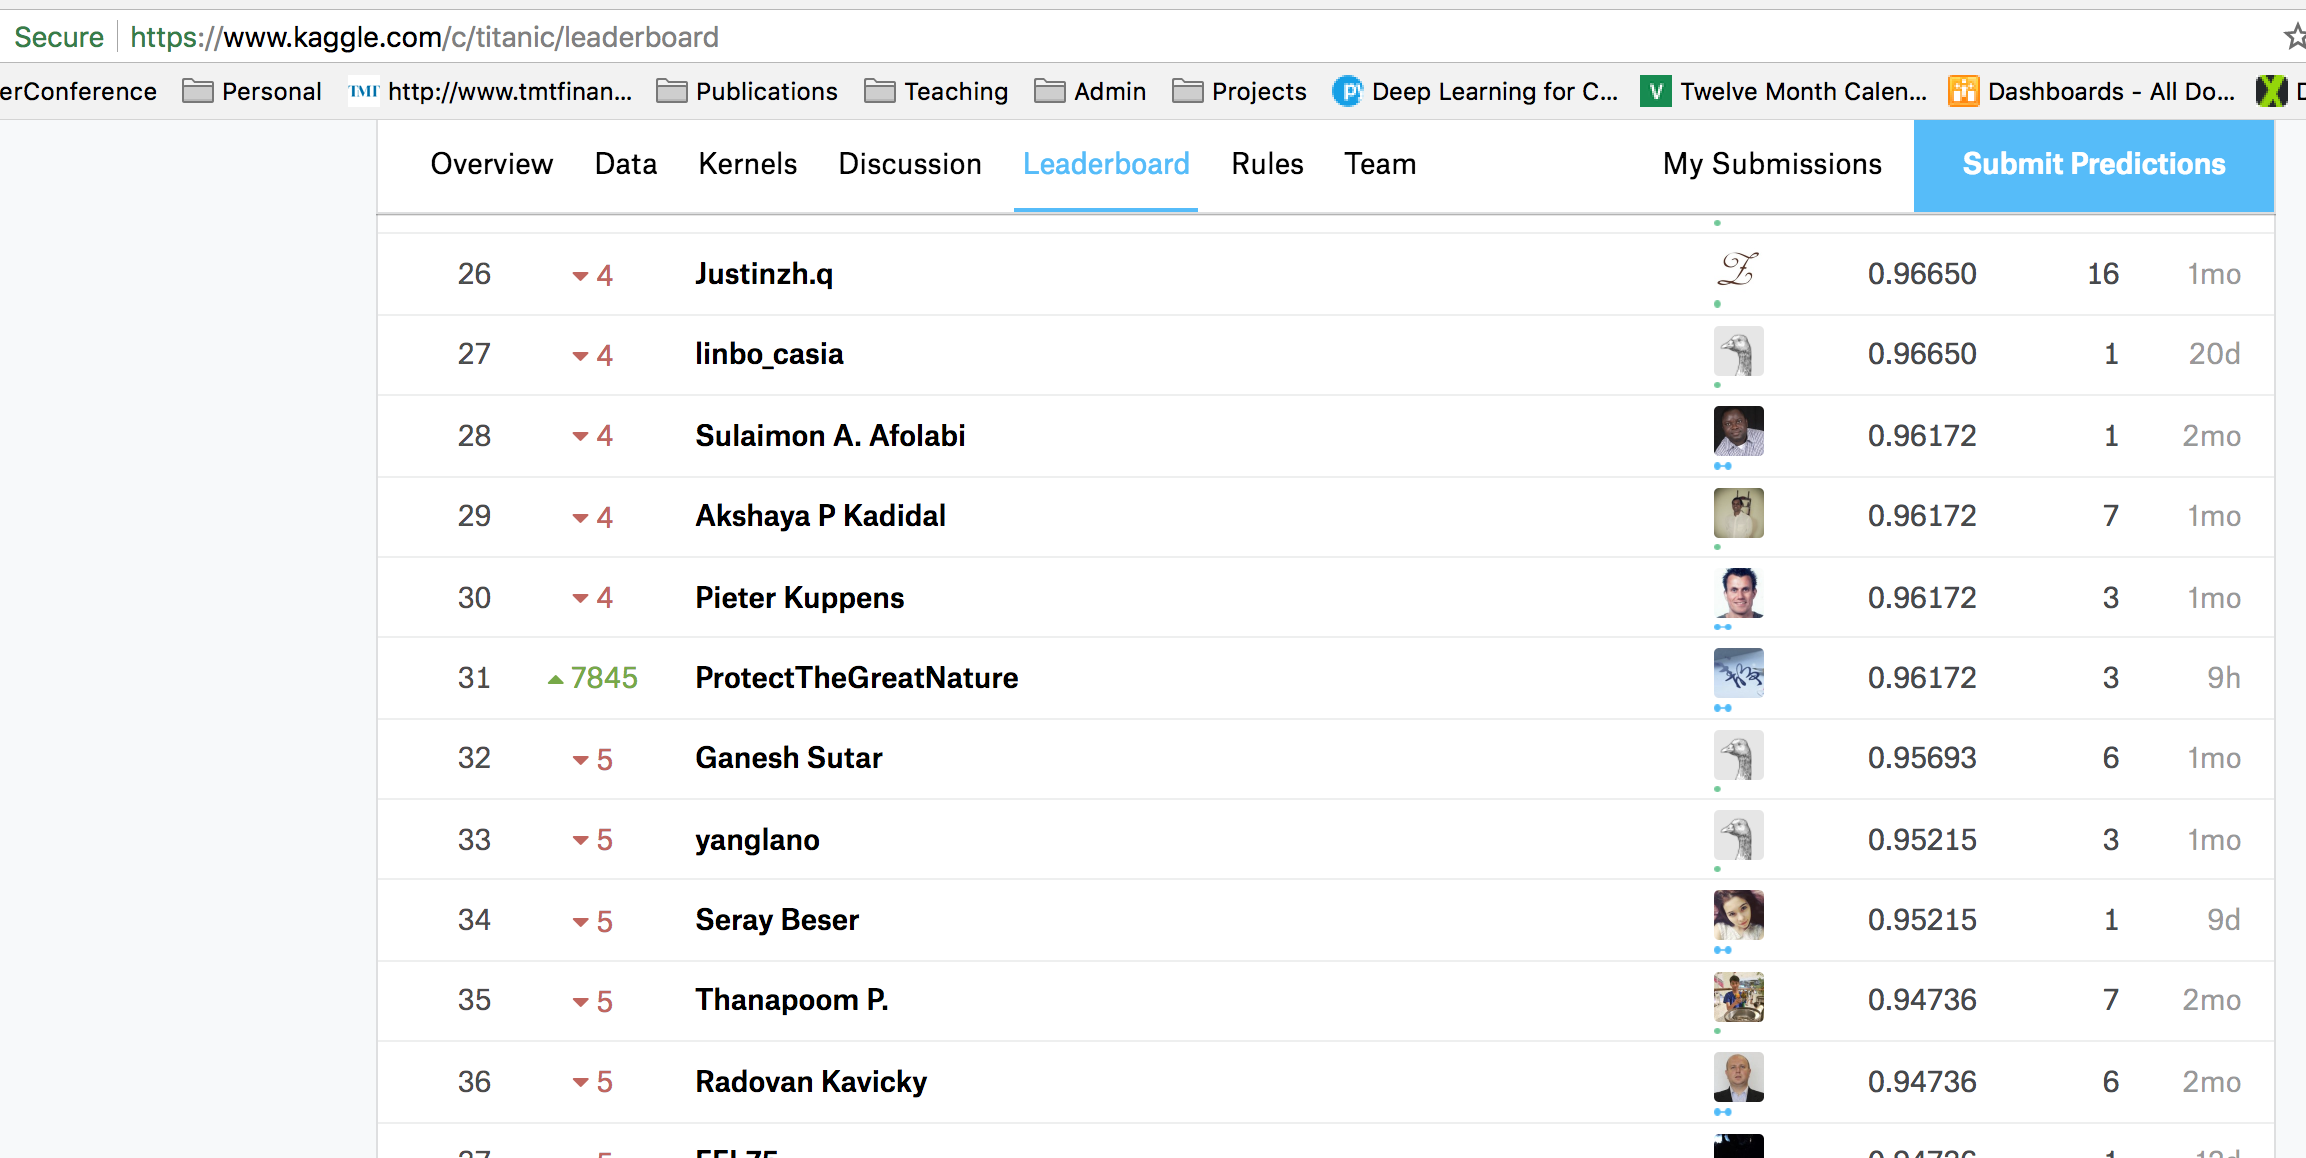

Answer

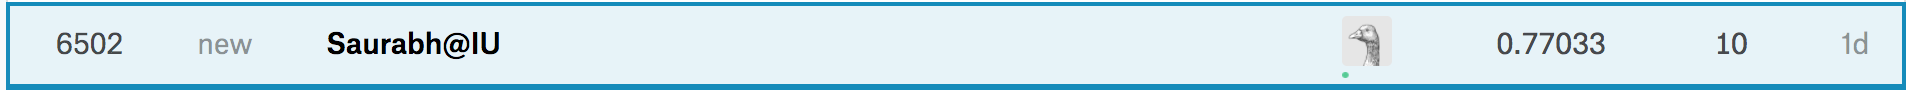

# Optional Task: Extend  your baseline ML Pipeline

Feature engineering is so important to how your model performs, that even a simple model with great features can outperform a complicated algorithm with poor ones. In fact, feature engineering has been described as easily the most important factor in determining the success or failure of your predictive model. Feature engineering really boils down to the human element in machine learning. How much you understand the data, with your human intuition and creativity, can make the difference. 

The following [webpage](http://trevorstephens.com/kaggle-titanic-tutorial/r-part-4-feature-engineering/) has some great ideas for creating new features. Please extend the baseline pipeline and incorporate the following features as described in this webpage:
* Title 
* FamilySize 
* FamilyID2

Using your extended Titanic Survival pipeline, prepare a submission to the Kaggle Titanic competition. For details on how to do this see [here]( https://www.kaggle.com/c/titanic).

For your best run, please paste a screenshot of your ranking on the Kaggle Titanic competition scoreboard here (make sure the cell is in markdown mode; then paste the image/screen shot in the cell; then execute the cell. Please report your rank, accuracy, and Kaggle username in text here also.



 Answer: Done in Section 15 above